In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd

In [48]:
from sklearn.impute import KNNImputer

def preprocessing(dataExport):
    imputer = KNNImputer(n_neighbors=2)

    #dataExport[dataExport.eq("Eyetracker Calibration").any(1)]['Presented Stimulus name']
#     calibrationEnd = dataExport[dataExport.eq("Eyetracker Calibration").any(1)]['Presented Stimulus name'].index.to_list()[-1]
    
#     calibrationEnd+=1
    
    calibration_rows = dataExport[dataExport['Presented Stimulus name'].eq("Eyetracker Calibration")]

    # Get the index of the last row where 'Event' column equals "Eyetracker Calibration"
    calibrationEnd = calibration_rows.index[-1] + 1  # Add 1 to include the last row
    
    dataExport = dataExport[["Eyetracker timestamp [μs]", "Event", "Event value", "Gaze point X [MCS norm]", "Gaze point Y [MCS norm]", "Eye movement type", 
    "Presented Stimulus name", 'AOI hit [slothStimulus-final (1) - sloth1]',
       'AOI hit [slothStimulus-final (1) - sloth2]',
       'AOI hit [slothStimulus-final (1) - sloth3]',
       'AOI hit [slothStimulus-final (1) - sloth4]',
       'AOI hit [slothStimulus-final (1) - sloth5]',
       'AOI hit [slothStimulus-final (1) - sloth6]',
       'AOI hit [slothStimulus-final (1) - sloth7]',
       'AOI hit [slothStimulus-final (1) - sloth8]',
       'AOI hit [slothStimulus-final (1) - sloth9]',
       'AOI hit [slothStimulus-final (1) - sloth10]',
       'AOI hit [slothStimulus-final (1) - sloth11]',
       'AOI hit [catStimulus-final (1) - cat1]',
        'AOI hit [catStimulus-final (1) - cat2]',
       'AOI hit [catStimulus-final (1) - cat3]',
       'AOI hit [catStimulus-final (1) - cat4]',
       'AOI hit [catStimulus-final (1) - cat5]',
       'AOI hit [catStimulus-final (1) - cat6]',
       'AOI hit [catStimulus-final (1) - cat7]',
       'AOI hit [catStimulus-final (1) - cat8]',
       'AOI hit [catStimulus-final (1) - cat9]',
       'AOI hit [catStimulus-final (1) - cat10]',
       'AOI hit [catStimulus-final (1) - cat11]',
        'Gaze point left X [MCS norm]', 'Gaze point left Y [MCS norm]', 'Gaze point right X [MCS norm]', 
                         'Gaze point right Y [MCS norm]', 
        'Gaze point left X [DACS px]', 'Gaze point left Y [DACS px]', 'Gaze point right X [DACS px]', 
                         'Gaze point right Y [DACS px]',  'Gaze point X [DACS px]',  'Gaze point Y [DACS px]'
                            ]]



    #Only isolate non calibration data
    dataExportWithoutCalibration = dataExport[calibrationEnd:]

    #Drop all columns with eye movement type of eyes not found
    dataExportWithoutCalibration = dataExportWithoutCalibration[dataExportWithoutCalibration['Eye movement type'] != 'EyesNotFound']

    #Convert the x and y coordinates into pixels and then into inches using ppi of 92.
    
    #Check this -
    #Normalized --> absolute pixels on the screen - ()
    dataExportWithoutCalibration[[ 'Gaze point X [MCS norm]', 'Gaze point left X [MCS norm]', 'Gaze point right X [MCS norm]']] = dataExportWithoutCalibration[[ 'Gaze point X [MCS norm]', 'Gaze point left X [MCS norm]', 'Gaze point right X [MCS norm]']]*1920/92 

    dataExportWithoutCalibration[[ 'Gaze point Y [MCS norm]', 'Gaze point left Y [MCS norm]', 'Gaze point right Y [MCS norm]']] = dataExportWithoutCalibration[[ 'Gaze point Y [MCS norm]', 'Gaze point left Y [MCS norm]', 'Gaze point right Y [MCS norm]']]*1080/92

    #Find the first timestamp that isn't nan: 
    # nonNanTimeStampSlothStart = dataExportWithoutCalibration['Eyetracker timestamp [μs]'].iloc[0]
    nonNanTimeStampSlothStart = dataExportWithoutCalibration.loc[dataExportWithoutCalibration['Eyetracker timestamp [μs]'].first_valid_index(), 'Eyetracker timestamp [μs]']

    #normalizes TIME when the calibration ends and stimulus sloth starts (at 0)
    dataExportWithoutCalibration['Eyetracker timestamp [μs]'] = dataExportWithoutCalibration['Eyetracker timestamp [μs]'] - nonNanTimeStampSlothStart #dataExportWithoutCalibration['Eyetracker timestamp [μs]'].iloc[0]

    #normalizes TIME when the sloth ends and cats start (at 0)
    #find the index where the cat stimulus begins
    indices = dataExportWithoutCalibration.index[dataExportWithoutCalibration['Presented Stimulus name'] == "catStimulus-final (1)"]

    #Find the beginning time for normalization
    beginTime = dataExportWithoutCalibration['Eyetracker timestamp [μs]'].loc[indices[0]]
    index_of_catBegin = (dataExportWithoutCalibration.index.tolist()).index(indices[0])
    onylCat = dataExportWithoutCalibration.index[index_of_catBegin:]
    #iterate through all times for cat stimulus and update
    for i in onylCat:
        dataExportWithoutCalibration.loc[i, 'Eyetracker timestamp [μs]'] = dataExportWithoutCalibration.loc[i, 'Eyetracker timestamp [μs]'] - beginTime

    

    #interpolate data
    columns_to_interpolate = ['Gaze point X [MCS norm]', 'Gaze point Y [MCS norm]', 'Gaze point left X [MCS norm]', 
                          'Gaze point left Y [MCS norm]', 'Gaze point right X [MCS norm]', 'Gaze point right Y [MCS norm]', 
                              'Gaze point left X [DACS px]', 'Gaze point left Y [DACS px]', 'Gaze point right X [DACS px]', 
                         'Gaze point right Y [DACS px]',  'Gaze point X [DACS px]',  'Gaze point Y [DACS px]'
                             ]
    
    

    # Use the subset parameter to interpolate only the specified columns

    dataExportWithoutCalibration[columns_to_interpolate] = dataExportWithoutCalibration[columns_to_interpolate].interpolate(method='polynomial', order =2 )
#     dataExportWithoutCalibration['Gaze point right X [MCS norm]'] = imputer.fit_transform(dataExportWithoutCalibration[['Gaze point right X [MCS norm]']])
#     dataExportWithoutCalibration['Gaze point right Y [MCS norm]'] = imputer.fit_transform(dataExportWithoutCalibration[['Gaze point right X [MCS norm]']])


    nan_df = dataExportWithoutCalibration.isna().sum()  # or df.isnull()
    print("LOOK HERE")
    print(nan_df)
    
#     display(dataExportWithoutCalibration['Gaze point right X [MCS norm]'][0:100])
    #isolate only saccade data
    mask = dataExportWithoutCalibration["Eye movement type"] == "Saccade"
    dfSaccade = dataExportWithoutCalibration[mask]
    excel_file_name = "thing"
#     dfSaccade.to_excel(os.path.join(os.getcwd(), excel_file_name), index=False)
#     dfSaccade.to_excel(os.path.join(os.getcwd(), excel_file_name + ".xlsx"), index=False, engine='xlsxwriter')

    
#     display(dfSaccade.head())
#     display(dfSaccade.tail())

    dfSaccade = dfSaccade[["Eyetracker timestamp [μs]", "Gaze point X [MCS norm]", "Gaze point Y [MCS norm]", 
        'Gaze point left X [MCS norm]', 'Gaze point left Y [MCS norm]', 'Gaze point right X [MCS norm]', 
                         'Gaze point right Y [MCS norm]', 
        'Gaze point left X [DACS px]', 'Gaze point left Y [DACS px]', 'Gaze point right X [DACS px]', 
                         'Gaze point right Y [DACS px]',  'Gaze point X [DACS px]',  'Gaze point Y [DACS px]'
                            ]]

    return dfSaccade, dataExportWithoutCalibration



In [77]:


# Define the Generator model
def build_generator(latent_dim, num_features):
    model = keras.Sequential([
        layers.Dense(128, activation='relu', input_dim=latent_dim),
        layers.Dense(256, activation='relu'),
        layers.Dense(num_features, activation='tanh')  # Output layer
    ])
    return model

# Define the Discriminator model
def build_discriminator(num_features):
    model = keras.Sequential([
        layers.Dense(128, activation='relu', input_dim=num_features),
        layers.Dense(64, activation='relu'),
        layers.Dense(1, activation='sigmoid')  # Output layer (binary classification)
    ])
    return model

# Define the GAN model
def build_gan(generator, discriminator):
    discriminator.trainable = False  # Freeze the discriminator during training
    model = keras.Sequential([
        generator,
        discriminator
    ])
    return model

# Define loss functions
cross_entropy = keras.losses.BinaryCrossentropy(from_logits=True)

# Define the discriminator loss
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

# Define the generator loss
def generator_loss(y_true, y_pred):
    return cross_entropy(tf.ones_like(y_pred), y_pred)


# Prepare the data
# Assume you have your real data stored in a numpy array called real_data

file_path = "11-29-data/Normal/SanaNormal.xlsx"
real_data = pd.read_excel(file_path)
real_data, x = preprocessing(real_data)

real_data = real_data.reset_index()
num_samples, num_features = real_data.shape
print(num_samples, num_features)
latent_dim = 100  # Dimensionality of the random noise input to the generator
real_data = real_data.to_numpy()
real_data = real_data.reshape(-1, num_features)
real_data_PLOT = real_data
display(real_data)

# Convert the NumPy array into a TensorFlow tensor
real_data = tf.convert_to_tensor(real_data, dtype=tf.float32)

# Create the models
generator = build_generator(latent_dim, num_features)
discriminator = build_discriminator(num_features)

# Build the GAN
gan = build_gan(generator, discriminator)

# Compile the models
generator_optimizer = keras.optimizers.Adam(learning_rate=0.0002)
discriminator_optimizer = keras.optimizers.Adam(learning_rate=0.0002)

generator.compile(optimizer=generator_optimizer, loss=generator_loss)
discriminator.compile(optimizer=discriminator_optimizer, loss=discriminator_loss)

discriminator.trainable = False  # Freeze the discriminator during training of the GAN
gan.compile(optimizer=discriminator_optimizer, loss=generator_loss)

# Use synthetic_data for further analysis or tasks


LOOK HERE
Eyetracker timestamp [μs]                        16
Event                                          7091
Event value                                    7092
Gaze point X [MCS norm]                          13
Gaze point Y [MCS norm]                          13
Eye movement type                                 1
Presented Stimulus name                          15
AOI hit [slothStimulus-final (1) - sloth1]     3555
AOI hit [slothStimulus-final (1) - sloth2]     3555
AOI hit [slothStimulus-final (1) - sloth3]     3555
AOI hit [slothStimulus-final (1) - sloth4]     3555
AOI hit [slothStimulus-final (1) - sloth5]     3555
AOI hit [slothStimulus-final (1) - sloth6]     3555
AOI hit [slothStimulus-final (1) - sloth7]     3555
AOI hit [slothStimulus-final (1) - sloth8]     3555
AOI hit [slothStimulus-final (1) - sloth9]     3555
AOI hit [slothStimulus-final (1) - sloth10]    3555
AOI hit [slothStimulus-final (1) - sloth11]    3555
AOI hit [catStimulus-final (1) - cat1]         3553
AO

array([[3.59100000e+03, 5.83290000e+04, 1.30560000e+01, ...,
        7.15059875e+02, 1.20100000e+03, 6.54000000e+02],
       [3.59700000e+03, 1.08329000e+05, 1.32417391e+01, ...,
        7.19397704e+02, 1.21800000e+03, 6.51000000e+02],
       [3.59800000e+03, 1.16663000e+05, 1.25718261e+01, ...,
        7.03813054e+02, 1.15700000e+03, 6.29000000e+02],
       ...,
       [1.02440000e+04, 2.56583990e+07, 1.15095652e+01, ...,
        5.39000000e+02, 1.05900000e+03, 5.46000000e+02],
       [1.02450000e+04, 2.56667320e+07, 1.10295652e+01, ...,
        4.81000000e+02, 1.01500000e+03, 5.03000000e+02],
       [1.02460000e+04, 2.56750660e+07, 1.07582609e+01, ...,
        4.71000000e+02, 9.90000000e+02, 4.88000000e+02]])

In [78]:
display(real_data)

<tf.Tensor: shape=(489, 14), dtype=float32, numpy=
array([[3.5910000e+03, 5.8329000e+04, 1.3056000e+01, ..., 7.1505988e+02,
        1.2010000e+03, 6.5400000e+02],
       [3.5970000e+03, 1.0832900e+05, 1.3241739e+01, ..., 7.1939771e+02,
        1.2180000e+03, 6.5100000e+02],
       [3.5980000e+03, 1.1666300e+05, 1.2571826e+01, ..., 7.0381305e+02,
        1.1570000e+03, 6.2900000e+02],
       ...,
       [1.0244000e+04, 2.5658400e+07, 1.1509565e+01, ..., 5.3900000e+02,
        1.0590000e+03, 5.4600000e+02],
       [1.0245000e+04, 2.5666732e+07, 1.1029565e+01, ..., 4.8100000e+02,
        1.0150000e+03, 5.0300000e+02],
       [1.0246000e+04, 2.5675066e+07, 1.0758261e+01, ..., 4.7100000e+02,
        9.9000000e+02, 4.8800000e+02]], dtype=float32)>

In [79]:
# Training loop
epochs = 100
batch_size = 128



for epoch in range(epochs):
    # Train the discriminator
#     idx = np.random.randint(0, num_samples, batch_size)
    print(idx[0])
    idx = tf.random.uniform(shape=[batch_size], minval=0, maxval=num_samples, dtype=tf.int32)
    real_samples = tf.gather(real_data, idx)
   

#     for i in range(0, len(idx)):
#         real_samples.iloc[i] = real_samples.iloc[i].astype(np.float32)  # Convert to float32
#         real_samples.iloc[i] = tensor = tf.convert_to_tensor(real_samples.iloc[i])
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    fake_samples = generator.predict(noise)

    d_loss_real = discriminator.train_on_batch(real_samples, np.ones((batch_size, 1)))
    d_loss_fake = discriminator.train_on_batch(fake_samples, np.zeros((batch_size, 1)))
    discriminator_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # Train the generator
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    g_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))

    # Print progress
    if epoch % 100 == 0:
        print(f"Epoch {epoch}/{epochs}, Discriminator Loss: {discriminator_loss}, Generator Loss: {g_loss}")

# Generate synthetic data
num_synthetic_samples = 1000
noise = np.random.normal(0, 1, (num_synthetic_samples, latent_dim))
synthetic_data = generator.predict(noise)


tf.Tensor(229, shape=(), dtype=int32)
4/4 [==============================] - 0s 1ms/step


/Users/sanmatichoudhary/anaconda3/lib/python3.11/site-packages/keras/src/backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Epoch 0/100, Discriminator Loss: 468317.12527549267, Generator Loss: 0.7071186304092407
tf.Tensor(210, shape=(), dtype=int32)
4/4 [==============================] - 0s 1ms/step
tf.Tensor(122, shape=(), dtype=int32)
4/4 [==============================] - 0s 1ms/step
tf.Tensor(176, shape=(), dtype=int32)
4/4 [==============================] - 0s 1ms/step
tf.Tensor(46, shape=(), dtype=int32)
4/4 [==============================] - 0s 1ms/step
tf.Tensor(257, shape=(), dtype=int32)
4/4 [==============================] - 0s 1ms/step
tf.Tensor(145, shape=(), dtype=int32)
4/4 [==============================] - 0s 1ms/step
tf.Tensor(371, shape=(), dtype=int32)
4/4 [==============================] - 0s 1ms/step
tf.Tensor(203, shape=(), dtype=int32)
4/4 [==============================] - 0s 1ms/step
tf.Tensor(212, shape=(), dtype=int32)
4/4 [==============================] - 0s 1ms/step
tf.Tensor(369, shape=(), dtype=int32)
4/4 [==============================] - 0s 1ms/step
tf.Tensor(374, shape=()

4/4 [==============================] - 0s 1ms/step
tf.Tensor(60, shape=(), dtype=int32)
4/4 [==============================] - 0s 1ms/step
tf.Tensor(89, shape=(), dtype=int32)
4/4 [==============================] - 0s 1ms/step
tf.Tensor(244, shape=(), dtype=int32)
4/4 [==============================] - 0s 1ms/step
tf.Tensor(68, shape=(), dtype=int32)
4/4 [==============================] - 0s 1ms/step
tf.Tensor(353, shape=(), dtype=int32)
4/4 [==============================] - 0s 1ms/step
tf.Tensor(393, shape=(), dtype=int32)
4/4 [==============================] - 0s 1ms/step
tf.Tensor(342, shape=(), dtype=int32)
32/32 [==============================] - 0s 905us/step


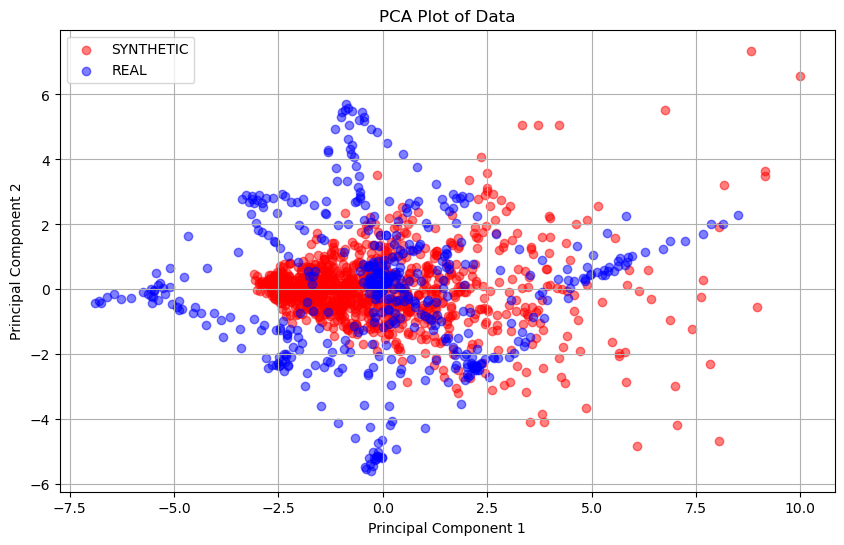

In [92]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Assuming real_data is your preprocessed data
# Perform feature scaling

real_data_PLOT = np.nan_to_num(real_data_PLOT, nan=0)

scaler = StandardScaler()
scaled_data = scaler.fit_transform(synthetic_data)
scaler = StandardScaler()
scaled_data_real = scaler.fit_transform(real_data_PLOT)


# Perform PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_data)
pca = PCA(n_components=2)
pca_data_real = pca.fit_transform(scaled_data_real)


# Create a DataFrame for the PCA data
pca_df = pd.DataFrame(data=pca_data, columns=['PC1', 'PC2'])
pca_df_real = pd.DataFrame(data=pca_data_real, columns=['PC1', 'PC2'])


# Plot the PCA data
plt.figure(figsize=(10, 6))
plt.scatter(pca_df['PC1'], pca_df['PC2'], alpha=0.5, color='red', label = 'SYNTHETIC')
plt.scatter(pca_df_real['PC1'], pca_df_real['PC2'], alpha=0.5, color='blue', label = 'REAL')
plt.legend()
plt.title('PCA Plot of Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()


In [89]:
nan_count_per_column = np.isnan(real_data_PLOT).sum(axis=0)

# If you prefer using isnull() instead of isna(), you can do:
# nan_count_per_column = df.isnull().sum()

print(nan_count_per_column)
nan_indices = np.where(np.isnan(real_data_PLOT))
print(nan_indices)

print(real_data_PLOT[13,1])

[0 1 0 0 0 0 0 0 0 0 0 0 0 0]
(array([13]), array([1]))
nan
